## Predicting Recurrence/Non-Recurrence in Breast Cancer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

## 1. Data Preparation

### Read in cancer data and metadata

In [2]:
cancer = pd.read_csv("data/GSE131512_cancerTPM.txt", sep = '\t')
metadata = pd.read_csv("data/metadata.csv")

In [3]:
cancer.shape

(60675, 96)

In [4]:
metadata.shape

(128, 9)

### Map each ENSG ID to Gene IDs

In [5]:
ens_to_sym = pd.read_csv("data/ensembl_to_symbol.txt", sep = '\t')
ens_to_sym = ens_to_sym.dropna()
ens_to_sym = dict(zip(ens_to_sym.Ensembl, ens_to_sym.Symbol))
keep = set(list(cancer.index)).intersection(set(ens_to_sym.keys()))
ens_to_sym = {k: ens_to_sym[k] for k in keep}
cancer = cancer[cancer.index.isin(ens_to_sym.keys())]
cancer = cancer.rename(index=ens_to_sym)
cancer.shape

(41355, 96)

In [6]:
cancer.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96
TSPAN6,7.071605,60.610797,58.255903,29.917356,24.500322,25.311091,37.394452,15.354658,24.839014,24.591295,...,14.134044,10.803910,6.068982,12.714350,15.983392,0.000000,38.189128,15.608352,51.519267,30.805593
TNMD,13.279391,47.424080,60.455497,6.482332,53.675826,31.686900,32.409716,0.000000,48.976056,46.178684,...,0.000000,12.172853,136.759411,28.650721,0.000000,0.000000,5.976111,6.280734,241.863225,0.000000
DPM1,0.000000,0.000000,23.040206,8.646690,20.456404,42.266702,21.615428,11.538256,18.665274,76.996356,...,79.657691,8.118597,0.000000,0.000000,0.000000,179.178412,15.942897,0.000000,0.000000,0.000000
SCYL3,6.212355,2.218590,12.120963,6.065120,16.142519,37.059356,7.580945,0.000000,0.000000,21.603278,...,18.624986,15.660412,33.988677,0.000000,36.858404,83.788404,18.172309,2.938248,14.547636,10.148436
FIRRM,34.038592,35.828348,55.926653,10.494273,14.482668,19.236768,13.117055,4.667898,18.877984,12.459809,...,17.903438,19.706680,23.062537,1.932615,28.344382,3.020339,27.411791,1.694651,3.729079,7.804221


### Filter for the Prior Association Genes

In [7]:
prior = "data/prior_association.txt"
with open(prior) as data:
    lines = [line.rstrip() for line in data]
prior = lines[0]
prior = prior.split(", ")
prior = list(set(prior))
cancer = cancer[cancer.index.isin(prior)]
cancer = cancer.transpose()
scaler = StandardScaler()
cancer = scaler.fit_transform(cancer)
status = list(metadata["recurStatus"])
binary = []
for c in status:
    if c == "R":
        binary.append(1)
    elif c == "N":
        binary.append(0)
X = cancer
y = list(binary)

## 2. Modeling

Explore some models, such as SVM, Logistic Regression, Random Forest Classifier, and Gradient Boosted Classifier

### SVM

In [8]:
clf = SVC(C = 10)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())

Average AUROC with 10-fold CV: 0.7777777777777778


### Logistic Regression

In [9]:
clf = LogisticRegression(C = 10)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())

Average AUROC with 10-fold CV: 0.7611111111111112


In [10]:
clf = LogisticRegression(C = 10, penalty = "l1", solver = 'liblinear')
cv_results = cross_validate(clf, X, y, cv=10, return_estimator=True)
model_coefs = []
for model in cv_results['estimator']:
    model_coefs.append(model.coef_)

### Random Forest

In [11]:
clf = RandomForestClassifier(max_depth = 20)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())

Average AUROC with 10-fold CV: 0.5619047619047619


### Gradient Boosted Tree

In [12]:
clf = GradientBoostingClassifier(n_estimators = 50)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())

Average AUROC with 10-fold CV: 0.6626984126984128


### ROC for SVM

In [62]:
def svm_roc(X, y):
    
    y = label_binarize(y, classes=[0, 1])
    n_classes = y.shape[1]

    # Create a cross-validation strategy
    cv = StratifiedKFold(n_splits=10)

    # Classifier
    svm = SVC(C = 10, probability = True)

    # Variables to collect results
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y.ravel())):
        # Train the model
        svm.fit(X[train], y[train].ravel())
        # Predict probabilities
        y_proba = svm.predict_proba(X[test])
    
        # Compute ROC curve and area the curve
        fpr, tpr, _ = roc_curve(y[test].ravel(), y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    
        # Plotting each fold
        ax.plot(fpr, tpr, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the average ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    # Plot luck line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    # Set graph labels and legend
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC of 10-Fold SVM, >=45th Percentile Laplacian Centrality Genes")
    ax.set_xlabel("Mean FPR")
    ax.set_ylabel("Mean TPR")
    ax.legend(loc="lower right", prop={'size': 8})
    plt.show()

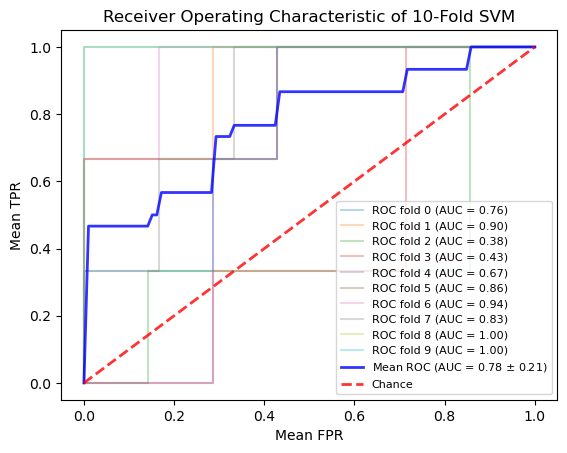

In [26]:
svm_roc(X, y)

## 3. Find optimal hyperparameters

### SVM hyperparameter tuning

In [29]:
parameters = {'kernel':('poy', 'linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', cv = 10)
clf.fit(X, y)
print("SVM best 10-fold score", clf.best_score_)
print("SVM best parameters", clf.best_params_)

SVM best 10-fold score 0.7777777777777778
SVM best parameters {'C': 10, 'kernel': 'rbf'}


### Logistic Regression hyperparameter tuning

In [30]:
parameters = {'penalty': ('l1', 'l2', 'elasticnet', None), 'C': [1,10]}
lg = LogisticRegression()
clf = GridSearchCV(lg, parameters, scoring = 'roc_auc', cv = 10)
clf.fit(X, y)
print("Log Reg best 10-fold score", clf.best_score_)
print("Log Reg best parameters", clf.best_params_)

Log Reg best 10-fold score 0.7611111111111112
Log Reg best parameters {'C': 10, 'penalty': 'l2'}


### Random Forest hyperparameter tuning

In [14]:
parameters = {'n_estimators': [10, 50, 100], 'max_depth': [10, 20, None], 'min_samples_split': [2,3,4]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring = 'roc_auc', cv = 10)
clf.fit(X, y)
print("RF best 10-fold score", clf.best_score_)
print("RF best parameters", clf.best_params_)

RF best 10-fold score 0.7134920634920635
RF best parameters {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 100}


## 4. Use a STRING PPI Network to select top genes based on centrality

In [27]:
G = nx.read_edgelist("data/prior_interactome_full.txt", delimiter = '\t')
G = G.to_undirected()
len(set(list(G.nodes)).intersection(set(prior)))

509

### Degree Centrality

In [28]:
deg_centrality = nx.degree_centrality(G)
df_describe = pd.DataFrame(np.asarray(list(deg_centrality.values())))
df_describe.describe()

,0
count,606.000000
mean,0.031940
std,0.044533
min,0.001653
25%,0.004959
50%,0.011570
75%,0.041322
max,0.319008


### Closeness Centrality

In [29]:
close_centrality = nx.closeness_centrality(G)
df_describe = pd.DataFrame(np.asarray(list(close_centrality.values())))
df_describe.describe()

,0
count,606.000000
mean,0.335917
std,0.077259
min,0.001653
25%,0.297651
50%,0.344948
75%,0.388463
max,0.534718


### Betweeness Centrality

In [30]:
between_centrality = nx.betweenness_centrality(G)
df_describe = pd.DataFrame(np.asarray(list(between_centrality.values())))
df_describe.describe()

,0
count,606.000000
mean,0.003126
std,0.008528
min,0.000000
25%,0.000014
50%,0.000409
75%,0.003283
max,0.115487


### Eigencentrality

In [31]:
eig_centrality = nx.eigenvector_centrality(G)
df_describe = pd.DataFrame(np.asarray(list(eig_centrality.values())))
df_describe.describe()

,0
count,6.060000e+02
mean,2.146216e-02
std,3.451821e-02
min,1.491758e-31
25%,8.570052e-04
50%,4.711586e-03
75%,2.370629e-02
max,1.585476e-01


### Laplacian Centrality

In [32]:
laplace_centrality = nx.laplacian_centrality(G)
df_describe = pd.DataFrame(np.asarray(list(laplace_centrality.values())))
df_describe.describe()

,0
count,606.000000
mean,0.004893
std,0.008911
min,0.000006
25%,0.000210
50%,0.001031
75%,0.005556
max,0.079225


### Function to model on select set of central genes based on a percentile threshold

In [33]:
def model_central_genes(cancer, centralities, y):
    
    values = np.asarray(list(centralities.values()))
    cross_val_scores = {}
    for percentile in range(5, 96, 5):
        cutoff = np.percentile(values, percentile)
        central_genes = [gene for gene in centralities.keys() if centralities[gene] >= cutoff]
        central_cancer = cancer[cancer.index.isin(central_genes)]
        central_cancer = central_cancer.transpose()
        central_cancer = StandardScaler().fit_transform(central_cancer)
    
        clf = SVC(C = 10)
        scores = cross_val_score(clf, central_cancer, y, scoring = 'roc_auc', cv=10)
        cross_val_scores[percentile] = scores.mean()
        
    return(cross_val_scores)

### Process data for model with just central genes

In [34]:
cancer = pd.read_csv("data/GSE131512_cancerTPM.txt", sep = '\t')
metadata = pd.read_csv("data/metadata.csv")
ens_to_sym = pd.read_csv("data/ensembl_to_symbol.txt", sep = '\t')
ens_to_sym = ens_to_sym.dropna()
ens_to_sym = dict(zip(ens_to_sym.Ensembl, ens_to_sym.Symbol))
keep = set(list(cancer.index)).intersection(set(ens_to_sym.keys()))
ens_to_sym = {k: ens_to_sym[k] for k in keep}
cancer = cancer[cancer.index.isin(ens_to_sym.keys())]
cancer = cancer.rename(index=ens_to_sym)
status = list(metadata["recurStatus"])
binary = []
for c in status:
    if c == "R":
        binary.append(1)
    elif c == "N":
         binary.append(0)
y = binary

### Run Models

In [37]:
deg_models = model_central_genes(cancer, deg_centrality, y)
close_models = model_central_genes(cancer, close_centrality, y)
between_models = model_central_genes(cancer, between_centrality, y)
eig_models = model_central_genes(cancer, eig_centrality, y)
laplace_models = model_central_genes(cancer, laplace_centrality, y)

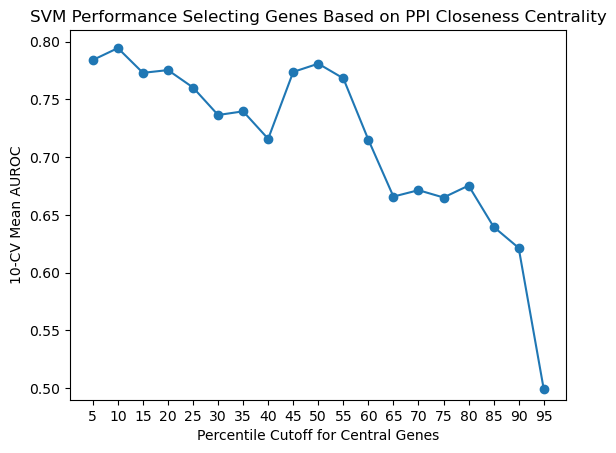

In [47]:
plt.plot(close_models.keys(), close_models.values(), "-o")
plt.xticks([i for i in range(5, 96, 5)])
plt.ylim(0.49, 0.81)
plt.xlabel("Percentile Cutoff for Central Genes")
plt.ylabel("10-CV Mean AUROC")
plt.title("SVM Performance Selecting Genes Based on PPI Closeness Centrality")
plt.show()

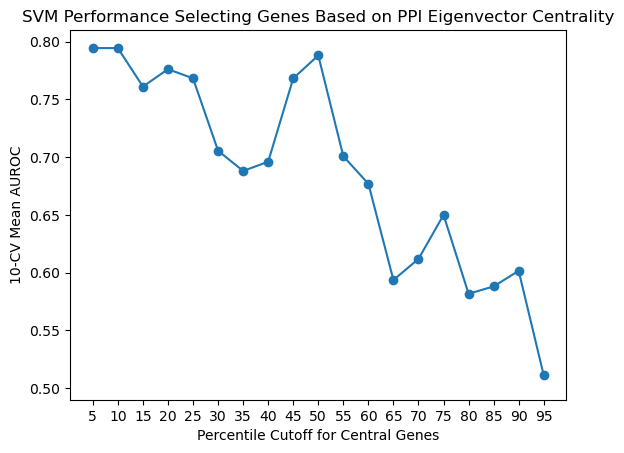

In [48]:
plt.plot(eig_models.keys(), eig_models.values(), "-o")
plt.xticks([i for i in range(5, 96, 5)])
plt.ylim(0.49, 0.81)
plt.xlabel("Percentile Cutoff for Central Genes")
plt.ylabel("10-CV Mean AUROC")
plt.title("SVM Performance Selecting Genes Based on PPI Eigenvector Centrality")
plt.show()

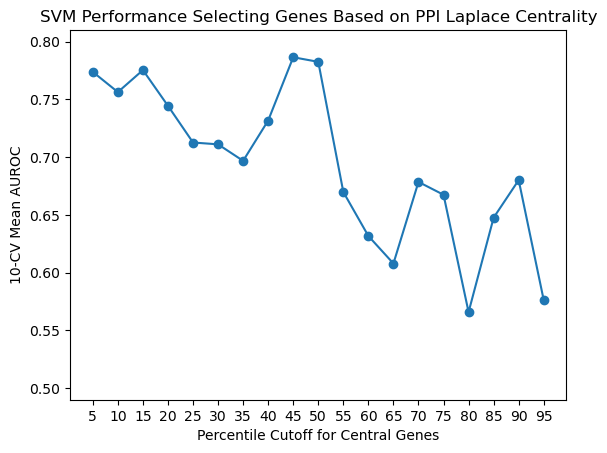

In [49]:
plt.plot(laplace_models.keys(), laplace_models.values(), "-o")
plt.xticks([i for i in range(5, 96, 5)])
plt.ylim(0.49, 0.81)
plt.xlabel("Percentile Cutoff for Central Genes")
plt.ylabel("10-CV Mean AUROC")
plt.title("SVM Performance Selecting Genes Based on PPI Laplace Centrality")
plt.show()

In [53]:
def cutoff_by_centrality(cancer, centralities, percentile):
    
    values = np.asarray(list(centralities.values()))
    cutoff = np.percentile(values, percentile)
    central_genes = [gene for gene in centralities.keys() if centralities[gene] >= cutoff]
    central_cancer = cancer[cancer.index.isin(central_genes)]
    central_cancer = central_cancer.transpose()
    central_cancer = StandardScaler().fit_transform(central_cancer)
    
    return(central_cancer)

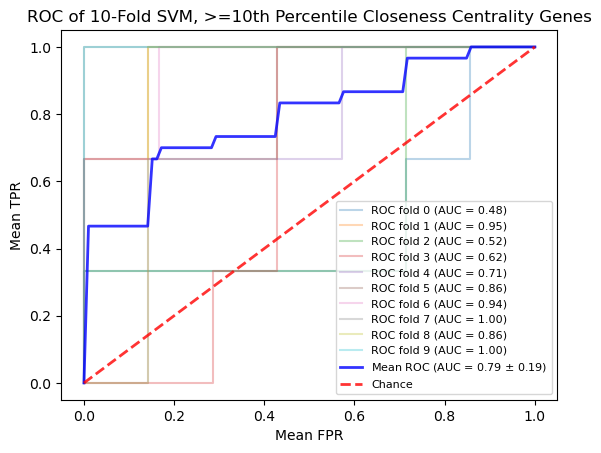

In [59]:
svm_roc(cutoff_by_centrality(cancer, close_centrality, 10), y)

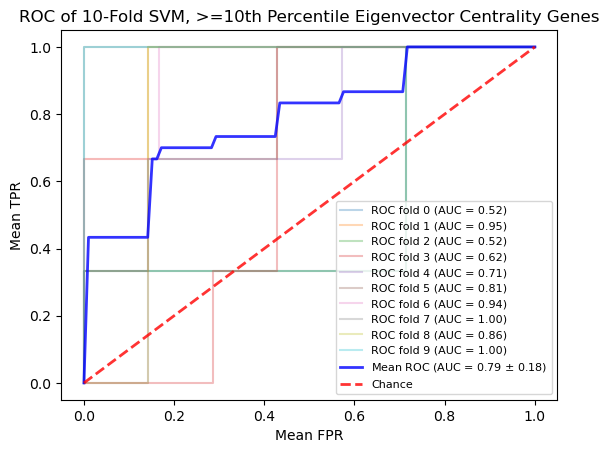

In [61]:
svm_roc(cutoff_by_centrality(cancer, eig_centrality, 10), y)

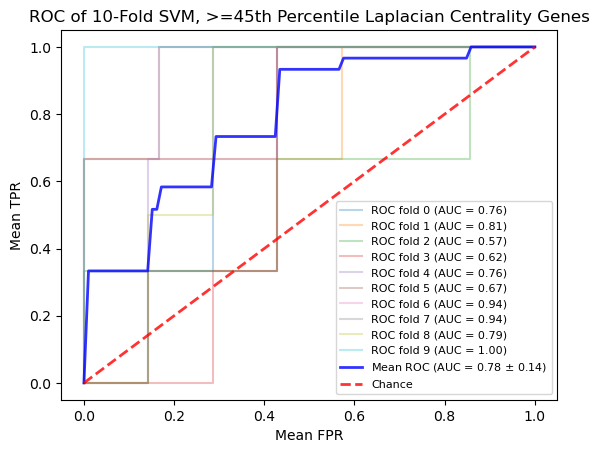

In [63]:
svm_roc(cutoff_by_centrality(cancer, laplace_centrality, 45), y)